# Time Series Project

By: Chris Everts 

"The goal of this mini-project is to practice what you have learned at each stage of the pipeline throughout the time series module. You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful)."

Planning: I'm going to predict average temperature for a specific state. After observing our file, I've decided I will be looking at average temperatures in Texas (USA) and see if I can predict them for future use. Since there are missing values, I will have to take care of those and potentially clean the data for usage.

I'll explore the data to see if there are any noticeable trends with earth surface temperature across time, such as months or years. Exploring may also help me see what cutoffs I want to use. Once I split my data, I should make some models and evaluate them based on RMSE scores. The lowest one will move onto my testing phase. Last, I'll make a forecast for the next upcoming year.

I'll also take note of things I will want to do with more time.


Executive Summary: Using previous year's cycle to predict average temperatures worked the best. I was able to get a lower RMSE score to predict 2012, and used it to forecast 2013. Since there is a slight upward trend over time, I don't believe my model will be able to predict several years out.

In [72]:
# Imports

# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#functions
import climate_func as c
import pmdarima as pm

In [2]:
df = c.get_temp_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [4]:
def prepare_temp_data(df):
    df['dt'] = pd.to_datetime(df.dt)
    df = df.loc[df['State'] == 'Texas']
    df = df.interpolate(method='linear')
    df = df.rename(columns={'dt':'date','AverageTemperature':'avg_temp','AverageTemperatureUncertainty':'avg_temp_unc','State':'state','Country':'country'})
    df = df.set_index('date')
    df['year']= df.index.year
    df['month']= df.index.month
    df = df.loc['1855':'2013']
    return df

In [5]:
df = prepare_temp_data(df)

In [6]:
df.tail(5)

,avg_temp,avg_temp_unc,state,country,year,month
date,,,,,,
2013-05-01,22.628,0.158,Texas,United States,2013,5
2013-06-01,27.841,0.220,Texas,United States,2013,6
2013-07-01,27.630,0.182,Texas,United States,2013,7
2013-08-01,28.663,0.247,Texas,United States,2013,8
2013-09-01,26.408,1.112,Texas,United States,2013,9


# Explore

<AxesSubplot:xlabel='year'>

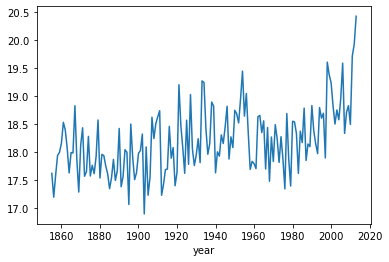

In [7]:
#how does average temperature change over the years starting with 1855?
df.groupby('year').avg_temp.mean().plot()

<AxesSubplot:xlabel='month'>

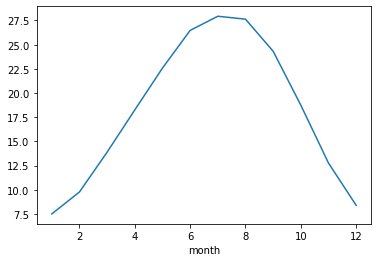

In [8]:
#how does average temperature change over the months within a year?
df.groupby('month').avg_temp.mean().plot()

<AxesSubplot:>

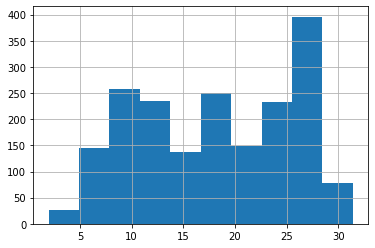

In [9]:
#average temp distribution
df.avg_temp.hist()

<AxesSubplot:xlabel='year'>

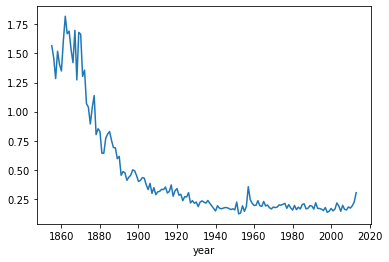

In [10]:
#how does the unvertainty change over all of these years?
df.groupby('year').avg_temp_unc.mean().plot()

### Takeaways 

- Temps in Texas had a gradual increase from 1855 to 2013
- The month time period revealed a temp increase during the summer months to decrease during the winter months

Now, I'm going to split my data. Since I only want to focus on average temperatures, I'll drop the rest of the columns

In [11]:
#Only going to look at date, and average temperature
df = df[['avg_temp']]


In [12]:
#50% of our data goes to train
train_size = int(len(df)*0.5)

In [13]:
#30% goes to validate
validate_size = int(len(df)*0.3)

In [14]:
#test gets 20% aka what is left over
test_size = int(len(df)-train_size - validate_size)

In [15]:
#establishing that the end of the validate set is the length of train size and validate size combined
validate_end_index = train_size + validate_size

In [16]:
#train
train = df[:train_size]
#validate
validate = df[train_size:validate_end_index]
#test
test = df[validate_end_index:]

In [17]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


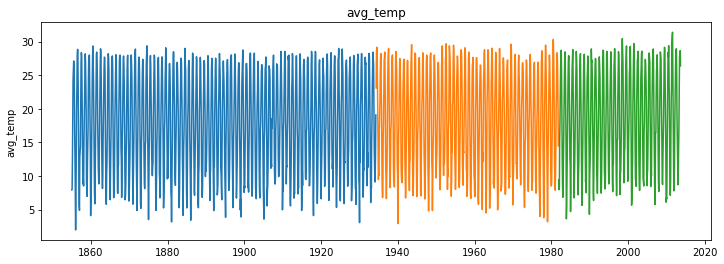

In [18]:
#looking at our splits
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    
    plt.ylabel(col)
    plt.title(col)

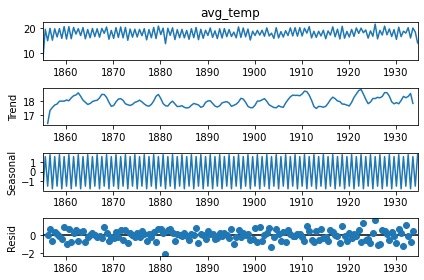

In [19]:
#seasonal decomposition - 6 months
sm.tsa.seasonal_decompose(train.avg_temp.resample('6M').mean()).plot()
None

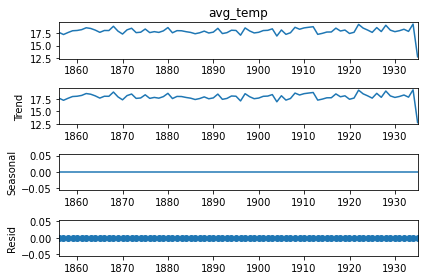

In [20]:
#seasonal decomposition - 1 year
sm.tsa.seasonal_decompose(train.avg_temp.resample('Y').mean()).plot()
None

In [21]:
#further exploration with average temperature
y = train.avg_temp

<AxesSubplot:xlabel='date'>

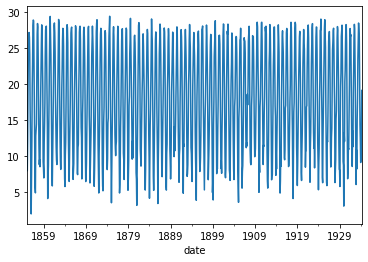

In [22]:
#let's take a look at our training data
y.plot()

<AxesSubplot:xlabel='date'>

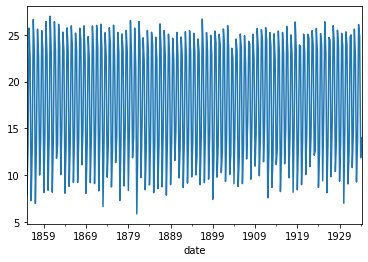

In [23]:
y.resample('3M').mean().plot()

- Temps are consistent with an slightly upward trend

<AxesSubplot:xlabel='date'>

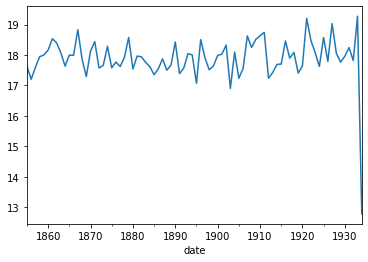

In [24]:
y.resample('Y').mean().plot()

<AxesSubplot:xlabel='date'>

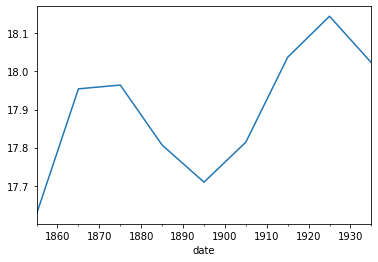

In [25]:
y.resample('10Y').mean().plot()

- gradual increase after 1900 or so

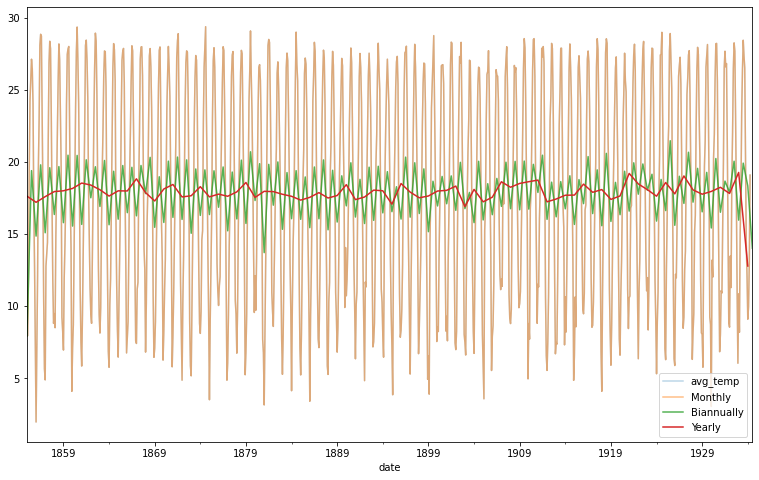

In [26]:
#average temperatures across various time periods
plt.figure(figsize=(13,8))
ax = y.plot(alpha=.3)
y.resample('M').mean().plot(ax=ax, alpha=.5, label='Monthly')
y.resample('6M').mean().plot(ax=ax, alpha=.8, label='Biannually')
y.resample('Y').mean().plot(ax=ax, label='Yearly')
ax.legend()
plt.show()

[Text(0.5, 1.0, 'Average Temperature Over Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temperature')]

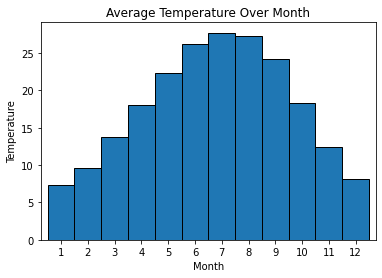

In [27]:
#average temperatures by month but in a bar chart. Coldest months are at the beginning and end of the year. 

ax = y.groupby(y.index.month).mean().plot.bar(width=1,ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature Over Month', xlabel='Month',ylabel='Temperature')

[Text(0.5, 0, 't'), Text(0, 0.5, 't+1')]

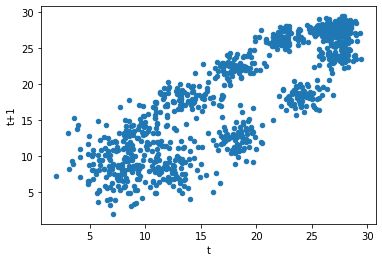

In [28]:
train['y(t+1)']=train.avg_temp.shift(-1)
ax=train.plot.scatter(x='avg_temp', y='y(t+1)')
ax.set(xlabel='t',ylabel='t+1')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

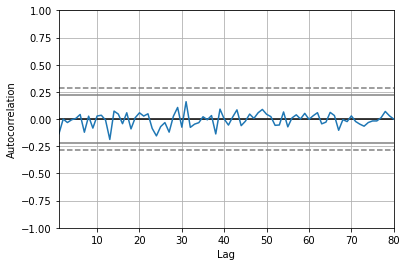

In [29]:
#auto correlation
pd.plotting.autocorrelation_plot(train.avg_temp.resample('Y').mean())

In [30]:
#drop from our train
train = train.drop(columns=['y(t+1)'])

# Modeling 

In [31]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    '''
    make a prediction column
    '''
    yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

    return yhat_df

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [32]:
# create an empty dataframe to store model type, our avg_temp, and its rmse.
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [33]:
#the last observed value
temp=train['avg_temp'][-1:][0]
temp

19.088

In [34]:
#predictions based on last observed value
yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
1934-05-01,19.088
1934-06-01,19.088
1934-07-01,19.088
1934-08-01,19.088
1934-09-01,19.088


avg_temp -- RMSE: 7


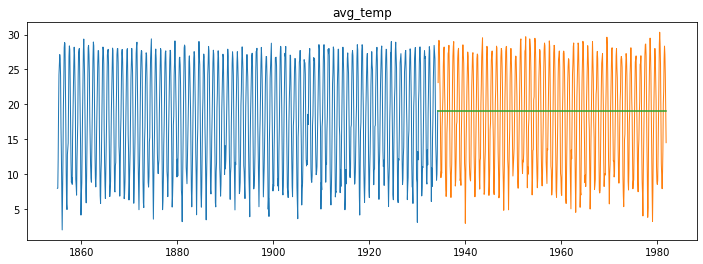

In [35]:
plot_and_eval('avg_temp')

In [36]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0


## Simple Average 

In [37]:
# compute simple average/the mean of avergae temperatures
temp = round(train['avg_temp'].mean(),2)
temp

17.93

In [38]:

#predictions with simple average
yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
1934-05-01,17.93
1934-06-01,17.93
1934-07-01,17.93
1934-08-01,17.93
1934-09-01,17.93


avg_temp -- RMSE: 7


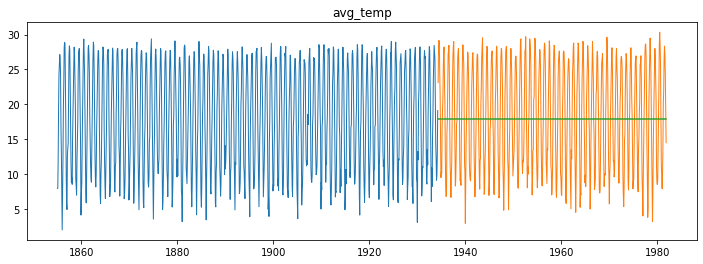

In [39]:
#visualize simple average predictions
plot_and_eval('avg_temp')

In [40]:
#append our simple averages RMSE to our evaluation dataframe
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0


In [41]:
#Let's look at the rolling average of 3 months 
period = 3

temp = round(train['avg_temp'].rolling(period).mean()[-1],2)
print(temp)

14.01


In [42]:
yhat_df = make_predictions()
yhat_df.head(5)

,avg_temp
date,
1934-05-01,14.01
1934-06-01,14.01
1934-07-01,14.01
1934-08-01,14.01
1934-09-01,14.01


avg_temp -- RMSE: 9


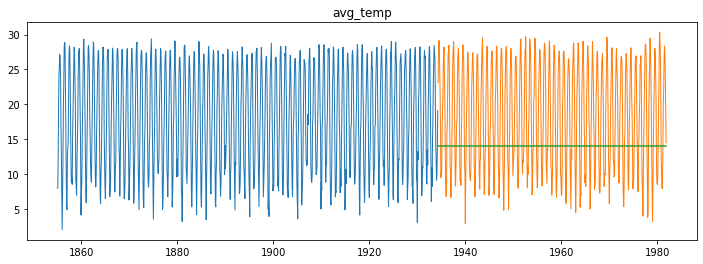

In [43]:
#visualize the rolling average of 3 months
plot_and_eval('avg_temp')

In [44]:
eval_df = append_eval_df(model_type = '3 month_moving_avg', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
2,3 month_moving_avg,avg_temp,9.0


In [45]:
#let's test out 6 months, a year, a year and a half, 2 years, and 3 years for moving averages
periods = [6, 12, 18, 24, 36, 60]

for p in periods: 
    temp = round(train['avg_temp'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [46]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
2,3 month_moving_avg,avg_temp,9.0
3,6month_moving_avg,avg_temp,9.0
4,12month_moving_avg,avg_temp,7.0
5,18month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,7.0
7,36month_moving_avg,avg_temp,7.0
8,60month_moving_avg,avg_temp,7.0


In [47]:
# so far we have ties going
min_temp_rmse = eval_df[eval_df.target_var=='avg_temp']['rmse'].min()

eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
4,12month_moving_avg,avg_temp,7.0
6,24month_moving_avg,avg_temp,7.0
7,36month_moving_avg,avg_temp,7.0
8,60month_moving_avg,avg_temp,7.0


## Holts

In [48]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1,
                      smoothing_slope = 0.1,
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [49]:
#this model is bad
yhat_df

,avg_temp
date,
1934-05-01,17.12
1934-06-01,16.99
1934-07-01,16.86
1934-08-01,16.72
1934-09-01,16.59
...,...
1981-07-01,-57.71
1981-08-01,-57.85
1981-09-01,-57.98


avg_temp -- RMSE: 45


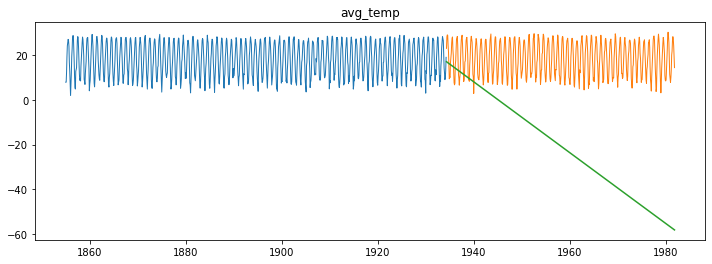

In [50]:
#visual proof
plot_and_eval('avg_temp')

In [51]:
#add the Holt model anyway
eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
4,12month_moving_avg,avg_temp,7.0
6,24month_moving_avg,avg_temp,7.0
7,36month_moving_avg,avg_temp,7.0
8,60month_moving_avg,avg_temp,7.0
5,18month_moving_avg,avg_temp,8.0
2,3 month_moving_avg,avg_temp,9.0
3,6month_moving_avg,avg_temp,9.0
9,holts_.1,avg_temp,45.0


In [52]:
#6 way tie
eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
4,12month_moving_avg,avg_temp,7.0
6,24month_moving_avg,avg_temp,7.0
7,36month_moving_avg,avg_temp,7.0
8,60month_moving_avg,avg_temp,7.0


## Based on Cycle

In [53]:
train = df[:'2010']
validate = df['2011']
test = df['2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1872, 1)
(12, 1)
(12, 1)


,avg_temp
date,
2010-08-01,29.393
2010-09-01,25.612
2010-10-01,19.645
2010-11-01,13.821
2010-12-01,9.478


In [54]:
#our prediction will be a year added to train (2010)
yhat_df = train['2010'] + train.diff(12).mean()

In [55]:
#prediction vs actual value
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp
date,
2010-01-01,6.75363
2011-01-01,7.12100


In [56]:
#set the indexes to each other
yhat_df.index = validate.index

avg_temp -- RMSE: 2


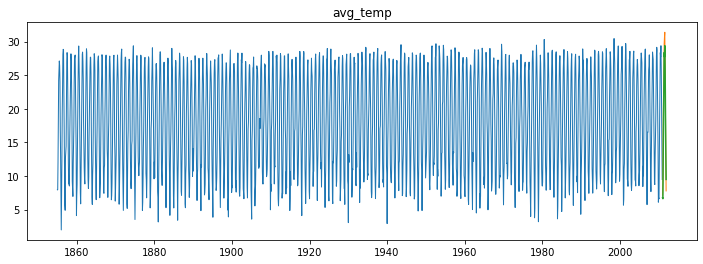

In [57]:
#visualize predictions for 2011 based off previous year cycle
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [58]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,7.0
1,simple_average,avg_temp,7.0
2,3 month_moving_avg,avg_temp,9.0
3,6month_moving_avg,avg_temp,9.0
4,12month_moving_avg,avg_temp,7.0
5,18month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,7.0
7,36month_moving_avg,avg_temp,7.0
8,60month_moving_avg,avg_temp,7.0
9,holts_.1,avg_temp,45.0


In [59]:
#let's predict 2012
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [60]:
#the rmse of the average temperature for our test, please.
rmse_temp = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_temp']))

In [61]:
print('rmse-temp: ', rmse_temp)

rmse-temp:  1.6903255715794252


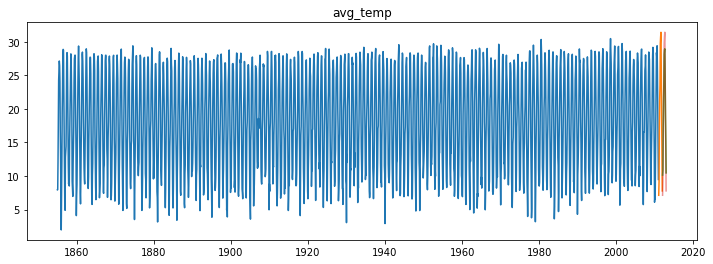

In [62]:
# plot
for col in train.columns:
    final_plot(col)

In [63]:
#2013 prediction
yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

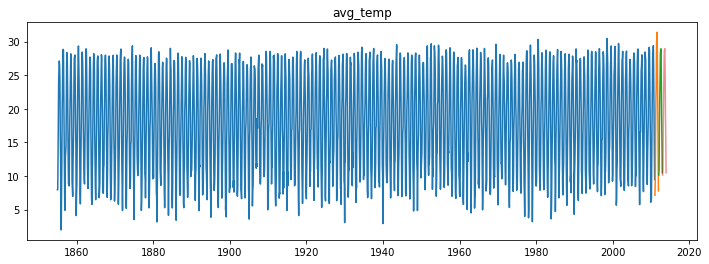

In [64]:
#final plot with prediction of 2013
final_plot(col)

# Conclusion:

-Using the previous year's cycle worked better than using last observed value, simple average, moving average, and Holt's. It had the lowest RMSE score

-Using previous year's cycle for test, I ended with an RMSE of 1.6

-With more time, I'd like to run ARIMA model and compare results

-Wonder how to incorporate the uncertainty column
